### Importing Necessary Libraries

In [1]:
import os
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization, LSTM, Concatenate
from tensorflow.keras.applications import EfficientNetV2L, EfficientNetV2S, Xception
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [2]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [3]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

In [4]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [5]:
roi_info = np.load('./Data/ROI-Extractions/train/train_roi_viz.npy')

In [6]:
roi_info.shape

(16000, 100, 6)

## Data Preparation

Below we load the visual features for each document as generated in [EfficientNet kPiece Model](EfficientNet-kPiece-Model.ipynb). We will use this for fine-tuning.

### Training Data

In [7]:
fine_tune_data_4P = np.load('./Data/EffNet-4P-train-precompute/whole_train_data_precomp.npy')
# fine_tune_data_4P = np.reshape(fine_tune_data_4P, (16000, -1))
fine_tune_data_4P.shape

(16000, 5, 1280)

In [8]:
fine_tune_data = np.load(f'./Data/EffNet-kP-train-precompute/whole_train_data_precomp.npy')

In [9]:
fine_tune_data.shape

(16000, 100, 1280)

In [10]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [11]:
fine_tune_data_train_4P = fine_tune_data_4P[list(train_labels['id'])]
fine_tune_data_train_4P.shape

(15200, 5, 1280)

In [12]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 100, 1280)

In [13]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [14]:
fine_tune_data_test_4P = fine_tune_data_4P[list(test_labels['id'])]
fine_tune_data_test_4P.shape

(800, 5, 1280)

In [15]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 100, 1280)

In [16]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

Now, we observe that the input vector for each image is $7680D$ which is pretty high dimensional. Since, it consistd of $6$ parts of $1280D$, on each part we use PCA to reduce the dimensions to a reasonable number.

In [17]:
N_COMPS = 512
pcas = [PCA(N_COMPS) for _ in range(5)]

In [18]:
for i in range(5):
    pcas[i].fit(fine_tune_data_train_4P[:,i,:])

In [19]:
fine_tune_data_train_4P_red = np.zeros((fine_tune_data_train_4P.shape[0], 5 * N_COMPS))
for i in range(5):
    fine_tune_data_train_4P_red[:,(N_COMPS*i):(N_COMPS*(i+1))] = pcas[i].transform(fine_tune_data_train_4P[:,i,:])

In [20]:
fine_tune_data_train_4P_red.shape

(15200, 2560)

In [21]:
fine_tune_data_test_4P_red = np.zeros((fine_tune_data_test_4P.shape[0], 5 * N_COMPS))
for i in range(5):
    fine_tune_data_test_4P_red[:,(N_COMPS*i):(N_COMPS*(i+1))] = pcas[i].transform(fine_tune_data_test_4P[:,i,:])

In [22]:
fine_tune_data_test_4P_red.shape

(800, 2560)

### Validation Data

In [23]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [24]:
roi_info_validation = np.load('./Data/ROI-Extractions/validation/validation_roi_viz.npy')
roi_info_validation.shape

(900, 100, 6)

In [25]:
fine_tune_data_validation_4P = np.load('./Data/EffNet-4P-validation-precompute/whole_validation_data_precomp.npy')
# fine_tune_data_4P = np.reshape(fine_tune_data_4P, (16000, -1))
fine_tune_data_validation_4P.shape

(900, 5, 1280)

In [26]:
fine_tune_data_validation = np.load(f'./Data/EffNet-kP-validation-precompute/whole_validation_data_precomp.npy')

In [27]:
fine_tune_data_validation.shape

(900, 100, 1280)

In [28]:
fine_tune_data_validation_4P_red = np.zeros((fine_tune_data_validation_4P.shape[0], 5 * N_COMPS))
for i in range(5):
    fine_tune_data_validation_4P_red[:,(N_COMPS*i):(N_COMPS*(i+1))] = pcas[i].transform(fine_tune_data_validation_4P[:,i,:])

In [29]:
fine_tune_data_validation_4P_red.shape

(900, 2560)

## Fine-Tuning Models

The fine-tuning part of our model.

In [30]:
def ftmodel():
    inputs = Input(shape=(5*N_COMPS))
    
    inputs_roi = Input(shape=(100, fine_tune_data_train.shape[-1]))
    y = LSTM(512, input_shape=(100, fine_tune_data_train.shape[-1]))(inputs_roi)
    
    x = Concatenate()([inputs, y])
    x = BatchNormalization()(x)
    top_dropout_rate = 0.3
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model([inputs, inputs_roi], outputs, name='EfficientNet-FineTune')
    return model1

In [31]:
model1 = ftmodel()
model1.summary()

Metal device set to: Apple M1 Max


2022-10-08 02:34:06.101448: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-08 02:34:06.101587: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "EfficientNet-FineTune"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 1280)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2560)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 512)          3672064     ['input_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 3072)         0           ['input_1[0][0]',                
                                                                  'lstm[0][0]'

In [32]:
# tf.keras.utils.plot_model(model1)

### Model Training

The fine-tuning will be done on the EfficientNet's $1280D$ representation vectors for $5$ pieces of the image and the averaged ROI representation vectors.

In [33]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [34]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/EfficientNet-kP-PCA-LSTM/auto-EffNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [35]:
history = model1.fit([fine_tune_data_train_4P_red, fine_tune_data_train], fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=([fine_tune_data_test_4P_red, fine_tune_data_test], fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
# history = model1.fit(fine_tune_data, fine_tune_labels, epochs=EPOCHS, batch_size=1600, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/EfficientNet-kP-PCA-LSTM/effnet-kp-model-weights")
model1.load_weights('./Models/EfficientNet-kP-PCA-LSTM/effnet-kp-model-weights')

Epoch 1/1000


2022-10-08 02:34:18.146884: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-08 02:34:18.988575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-08 02:34:20.031133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-08 02:34:20.621947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 3.0615 - accuracy: 0.1964

2022-10-08 02:34:40.815153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-08 02:34:40.953167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 23s 1s/step - loss: 3.0615 - accuracy: 0.1964 - val_loss: 2.7692 - val_accuracy: 0.3212
Epoch 2/1000
19/19 [==============================] - 21s 1s/step - loss: 2.0185 - accuracy: 0.4309 - val_loss: 2.7213 - val_accuracy: 0.3625
Epoch 3/1000
19/19 [==============================] - 20s 1s/step - loss: 1.6149 - accuracy: 0.5429 - val_loss: 2.6843 - val_accuracy: 0.3662
Epoch 4/1000
19/19 [==============================] - 20s 1s/step - loss: 1.4051 - accuracy: 0.5997 - val_loss: 2.6486 - val_accuracy: 0.3662
Epoch 5/1000
19/19 [==============================] - 20s 1s/step - loss: 1.2417 - accuracy: 0.6449 - val_loss: 2.6104 - val_accuracy: 0.3625
Epoch 6/1000
19/19 [==============================] - 20s 1s/step - loss: 1.1422 - accuracy: 0.6694 - val_loss: 2.5686 - val_accuracy: 0.3562
Epoch 7/1000
19/19 [==============================] - 20s 1s/step - loss: 1.0519 - accuracy: 0.6949 - val_loss: 2.5255 - val_accuracy: 0.3650
Epoch 8/1000
19/19 

19/19 [==============================] - 20s 1s/step - loss: 0.1383 - accuracy: 0.9793 - val_loss: 1.1444 - val_accuracy: 0.6925
Epoch 59/1000
19/19 [==============================] - 20s 1s/step - loss: 0.1342 - accuracy: 0.9823 - val_loss: 1.1559 - val_accuracy: 0.6962
Epoch 60/1000
19/19 [==============================] - 21s 1s/step - loss: 0.1335 - accuracy: 0.9825 - val_loss: 1.1423 - val_accuracy: 0.6875
Epoch 61/1000
19/19 [==============================] - 20s 1s/step - loss: 0.1280 - accuracy: 0.9839 - val_loss: 1.1403 - val_accuracy: 0.6850
Epoch 62/1000
19/19 [==============================] - 20s 1s/step - loss: 0.1257 - accuracy: 0.9846 - val_loss: 1.1473 - val_accuracy: 0.6875
Epoch 63/1000
19/19 [==============================] - 20s 1s/step - loss: 0.1211 - accuracy: 0.9861 - val_loss: 1.1510 - val_accuracy: 0.6850
Epoch 64/1000
19/19 [==============================] - 20s 1s/step - loss: 0.1241 - accuracy: 0.9844 - val_loss: 1.1559 - val_accuracy: 0.6912
Epoch 65/1000

19/19 [==============================] - 20s 1s/step - loss: 0.0740 - accuracy: 0.9957 - val_loss: 1.2534 - val_accuracy: 0.7063
Epoch 116/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0744 - accuracy: 0.9950 - val_loss: 1.2365 - val_accuracy: 0.7000
Epoch 117/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0742 - accuracy: 0.9957 - val_loss: 1.2302 - val_accuracy: 0.7075
Epoch 118/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0748 - accuracy: 0.9951 - val_loss: 1.2239 - val_accuracy: 0.7012
Epoch 119/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0741 - accuracy: 0.9950 - val_loss: 1.2353 - val_accuracy: 0.6987
Epoch 120/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0731 - accuracy: 0.9956 - val_loss: 1.2439 - val_accuracy: 0.6987
Epoch 121/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0735 - accuracy: 0.9948 - val_loss: 1.2401 - val_accuracy: 0.7000
Epoch 1

Epoch 172/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0613 - accuracy: 0.9965 - val_loss: 1.2971 - val_accuracy: 0.6975
Epoch 173/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0610 - accuracy: 0.9969 - val_loss: 1.3172 - val_accuracy: 0.6962
Epoch 174/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0601 - accuracy: 0.9972 - val_loss: 1.3235 - val_accuracy: 0.6912
Epoch 175/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0603 - accuracy: 0.9968 - val_loss: 1.3112 - val_accuracy: 0.6950
Epoch 176/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0600 - accuracy: 0.9970 - val_loss: 1.3142 - val_accuracy: 0.6962
Epoch 177/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0589 - accuracy: 0.9978 - val_loss: 1.3111 - val_accuracy: 0.6962
Epoch 178/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0612 - accuracy: 0.9964 - val_loss: 1.2927 - val_accuracy:

Epoch 229/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0547 - accuracy: 0.9974 - val_loss: 1.2946 - val_accuracy: 0.6987
Epoch 230/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0542 - accuracy: 0.9973 - val_loss: 1.3128 - val_accuracy: 0.7088
Epoch 231/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0542 - accuracy: 0.9972 - val_loss: 1.3019 - val_accuracy: 0.7012
Epoch 232/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0550 - accuracy: 0.9972 - val_loss: 1.3050 - val_accuracy: 0.7000
Epoch 233/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0537 - accuracy: 0.9973 - val_loss: 1.3060 - val_accuracy: 0.6962
Epoch 234/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0541 - accuracy: 0.9970 - val_loss: 1.3168 - val_accuracy: 0.6962
Epoch 235/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0551 - accuracy: 0.9966 - val_loss: 1.3196 - val_accuracy:

Epoch 286/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0511 - accuracy: 0.9977 - val_loss: 1.2994 - val_accuracy: 0.6937
Epoch 287/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0513 - accuracy: 0.9971 - val_loss: 1.3234 - val_accuracy: 0.6987
Epoch 288/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0495 - accuracy: 0.9976 - val_loss: 1.3240 - val_accuracy: 0.7063
Epoch 289/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0503 - accuracy: 0.9976 - val_loss: 1.3374 - val_accuracy: 0.7037
Epoch 290/1000
19/19 [==============================] - 19s 1s/step - loss: 0.0511 - accuracy: 0.9972 - val_loss: 1.3522 - val_accuracy: 0.7000
Epoch 291/1000
19/19 [==============================] - 19s 1s/step - loss: 0.0503 - accuracy: 0.9976 - val_loss: 1.3479 - val_accuracy: 0.7075
Epoch 292/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0505 - accuracy: 0.9976 - val_loss: 1.3430 - val_accuracy:

Epoch 343/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0496 - accuracy: 0.9978 - val_loss: 1.3765 - val_accuracy: 0.6950
Epoch 344/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0494 - accuracy: 0.9970 - val_loss: 1.3928 - val_accuracy: 0.6987
Epoch 345/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0485 - accuracy: 0.9976 - val_loss: 1.4041 - val_accuracy: 0.6937
Epoch 346/1000
19/19 [==============================] - 19s 1s/step - loss: 0.0490 - accuracy: 0.9978 - val_loss: 1.3907 - val_accuracy: 0.6950
Epoch 347/1000
19/19 [==============================] - 19s 1s/step - loss: 0.0499 - accuracy: 0.9975 - val_loss: 1.3774 - val_accuracy: 0.6975
Epoch 348/1000
19/19 [==============================] - 19s 1s/step - loss: 0.0497 - accuracy: 0.9970 - val_loss: 1.3727 - val_accuracy: 0.6987
Epoch 349/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0484 - accuracy: 0.9974 - val_loss: 1.3982 - val_accuracy:

Epoch 400/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0487 - accuracy: 0.9975 - val_loss: 1.4223 - val_accuracy: 0.6812
Epoch 401/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0483 - accuracy: 0.9979 - val_loss: 1.4282 - val_accuracy: 0.6962
Epoch 402/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0477 - accuracy: 0.9980 - val_loss: 1.4272 - val_accuracy: 0.6912
Epoch 403/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0472 - accuracy: 0.9980 - val_loss: 1.4352 - val_accuracy: 0.6950
Epoch 404/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0473 - accuracy: 0.9978 - val_loss: 1.4424 - val_accuracy: 0.6912
Epoch 405/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0479 - accuracy: 0.9972 - val_loss: 1.4374 - val_accuracy: 0.6950
Epoch 406/1000
19/19 [==============================] - 19s 1s/step - loss: 0.0469 - accuracy: 0.9982 - val_loss: 1.4185 - val_accuracy:

Epoch 457/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0464 - accuracy: 0.9978 - val_loss: 1.5090 - val_accuracy: 0.7113
Epoch 458/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0466 - accuracy: 0.9974 - val_loss: 1.5100 - val_accuracy: 0.6987
Epoch 459/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0470 - accuracy: 0.9979 - val_loss: 1.4727 - val_accuracy: 0.7000
Epoch 460/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0467 - accuracy: 0.9973 - val_loss: 1.4696 - val_accuracy: 0.7012
Epoch 461/1000
19/19 [==============================] - 19s 1s/step - loss: 0.0457 - accuracy: 0.9981 - val_loss: 1.4394 - val_accuracy: 0.7050
Epoch 462/1000
19/19 [==============================] - 19s 1s/step - loss: 0.0465 - accuracy: 0.9976 - val_loss: 1.4014 - val_accuracy: 0.7012
Epoch 463/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0474 - accuracy: 0.9974 - val_loss: 1.4027 - val_accuracy:

Epoch 514/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0458 - accuracy: 0.9980 - val_loss: 1.4400 - val_accuracy: 0.7012
Epoch 515/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0452 - accuracy: 0.9978 - val_loss: 1.4284 - val_accuracy: 0.7037
Epoch 516/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0458 - accuracy: 0.9979 - val_loss: 1.4064 - val_accuracy: 0.7050
Epoch 517/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0445 - accuracy: 0.9982 - val_loss: 1.4199 - val_accuracy: 0.7050
Epoch 518/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0457 - accuracy: 0.9979 - val_loss: 1.4204 - val_accuracy: 0.6987
Epoch 519/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0449 - accuracy: 0.9984 - val_loss: 1.4415 - val_accuracy: 0.7037
Epoch 520/1000
19/19 [==============================] - 19s 1s/step - loss: 0.0454 - accuracy: 0.9978 - val_loss: 1.4379 - val_accuracy:

Epoch 571/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0452 - accuracy: 0.9983 - val_loss: 1.3586 - val_accuracy: 0.6962
Epoch 572/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0450 - accuracy: 0.9982 - val_loss: 1.3453 - val_accuracy: 0.6937
Epoch 573/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0456 - accuracy: 0.9977 - val_loss: 1.3315 - val_accuracy: 0.6912
Epoch 574/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0442 - accuracy: 0.9981 - val_loss: 1.3541 - val_accuracy: 0.6825
Epoch 575/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0453 - accuracy: 0.9974 - val_loss: 1.2864 - val_accuracy: 0.6750
Epoch 576/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0439 - accuracy: 0.9984 - val_loss: 1.2871 - val_accuracy: 0.6787
Epoch 577/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0448 - accuracy: 0.9979 - val_loss: 1.3329 - val_accuracy:

Epoch 628/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0457 - accuracy: 0.9975 - val_loss: 1.4254 - val_accuracy: 0.7050
Epoch 629/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0449 - accuracy: 0.9982 - val_loss: 1.4367 - val_accuracy: 0.7100
Epoch 630/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0457 - accuracy: 0.9978 - val_loss: 1.4486 - val_accuracy: 0.6975
Epoch 631/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0437 - accuracy: 0.9986 - val_loss: 1.4238 - val_accuracy: 0.7025
Epoch 632/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0448 - accuracy: 0.9978 - val_loss: 1.4069 - val_accuracy: 0.7063
Epoch 633/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0455 - accuracy: 0.9980 - val_loss: 1.3966 - val_accuracy: 0.7100
Epoch 634/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0464 - accuracy: 0.9968 - val_loss: 1.3728 - val_accuracy:

Epoch 685/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0430 - accuracy: 0.9983 - val_loss: 1.4290 - val_accuracy: 0.6987
Epoch 686/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0423 - accuracy: 0.9988 - val_loss: 1.4411 - val_accuracy: 0.7050
Epoch 687/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0440 - accuracy: 0.9978 - val_loss: 1.4641 - val_accuracy: 0.6987
Epoch 688/1000
19/19 [==============================] - 19s 1s/step - loss: 0.0433 - accuracy: 0.9978 - val_loss: 1.4506 - val_accuracy: 0.6937
Epoch 689/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0429 - accuracy: 0.9980 - val_loss: 1.4746 - val_accuracy: 0.6937
Epoch 690/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0425 - accuracy: 0.9985 - val_loss: 1.4768 - val_accuracy: 0.6887
Epoch 691/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0431 - accuracy: 0.9979 - val_loss: 1.4274 - val_accuracy:

Epoch 742/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0429 - accuracy: 0.9982 - val_loss: 1.7025 - val_accuracy: 0.7000
Epoch 743/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0422 - accuracy: 0.9986 - val_loss: 1.6557 - val_accuracy: 0.7037
Epoch 744/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0434 - accuracy: 0.9978 - val_loss: 1.6398 - val_accuracy: 0.7125
Epoch 745/1000
19/19 [==============================] - 19s 1s/step - loss: 0.0427 - accuracy: 0.9982 - val_loss: 1.6079 - val_accuracy: 0.7125
Epoch 746/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0433 - accuracy: 0.9982 - val_loss: 1.5701 - val_accuracy: 0.7188
Epoch 747/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0440 - accuracy: 0.9980 - val_loss: 1.5442 - val_accuracy: 0.7200
Epoch 748/1000
19/19 [==============================] - 21s 1s/step - loss: 0.0432 - accuracy: 0.9984 - val_loss: 1.5483 - val_accuracy:

Epoch 799/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0425 - accuracy: 0.9981 - val_loss: 1.3886 - val_accuracy: 0.6962
Epoch 800/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0452 - accuracy: 0.9973 - val_loss: 1.4020 - val_accuracy: 0.6912
Epoch 801/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0424 - accuracy: 0.9983 - val_loss: 1.3740 - val_accuracy: 0.6925
Epoch 802/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0439 - accuracy: 0.9983 - val_loss: 1.4206 - val_accuracy: 0.6987
Epoch 803/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0440 - accuracy: 0.9974 - val_loss: 1.5415 - val_accuracy: 0.6975
Epoch 804/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0431 - accuracy: 0.9980 - val_loss: 1.6066 - val_accuracy: 0.7050
Epoch 805/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0443 - accuracy: 0.9974 - val_loss: 1.5691 - val_accuracy:

Epoch 856/1000
19/19 [==============================] - 19s 1s/step - loss: 0.0428 - accuracy: 0.9979 - val_loss: 1.4718 - val_accuracy: 0.7088
Epoch 857/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0428 - accuracy: 0.9982 - val_loss: 1.4824 - val_accuracy: 0.7088
Epoch 858/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0426 - accuracy: 0.9984 - val_loss: 1.4695 - val_accuracy: 0.7113
Epoch 859/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0435 - accuracy: 0.9984 - val_loss: 1.4594 - val_accuracy: 0.7050
Epoch 860/1000
19/19 [==============================] - 19s 1s/step - loss: 0.0442 - accuracy: 0.9974 - val_loss: 1.4530 - val_accuracy: 0.6987
Epoch 861/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0428 - accuracy: 0.9984 - val_loss: 1.4498 - val_accuracy: 0.6950
Epoch 862/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0427 - accuracy: 0.9980 - val_loss: 1.4451 - val_accuracy:

Epoch 913/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0420 - accuracy: 0.9984 - val_loss: 1.6293 - val_accuracy: 0.7063
Epoch 914/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0412 - accuracy: 0.9986 - val_loss: 1.6539 - val_accuracy: 0.7025
Epoch 915/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0414 - accuracy: 0.9984 - val_loss: 1.4529 - val_accuracy: 0.7012
Epoch 916/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0424 - accuracy: 0.9982 - val_loss: 1.3166 - val_accuracy: 0.6600
Epoch 917/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0408 - accuracy: 0.9984 - val_loss: 1.3250 - val_accuracy: 0.6675
Epoch 918/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0413 - accuracy: 0.9982 - val_loss: 1.3345 - val_accuracy: 0.6825
Epoch 919/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0415 - accuracy: 0.9983 - val_loss: 1.3538 - val_accuracy:

Epoch 970/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0405 - accuracy: 0.9988 - val_loss: 1.4138 - val_accuracy: 0.7212
Epoch 971/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0417 - accuracy: 0.9983 - val_loss: 1.4346 - val_accuracy: 0.7188
Epoch 972/1000
19/19 [==============================] - 21s 1s/step - loss: 0.0416 - accuracy: 0.9983 - val_loss: 1.4430 - val_accuracy: 0.7150
Epoch 973/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0417 - accuracy: 0.9982 - val_loss: 1.4509 - val_accuracy: 0.7100
Epoch 974/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0421 - accuracy: 0.9979 - val_loss: 1.4410 - val_accuracy: 0.7175
Epoch 975/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0408 - accuracy: 0.9986 - val_loss: 1.4569 - val_accuracy: 0.7138
Epoch 976/1000
19/19 [==============================] - 20s 1s/step - loss: 0.0418 - accuracy: 0.9983 - val_loss: 1.4309 - val_accuracy:

In [36]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

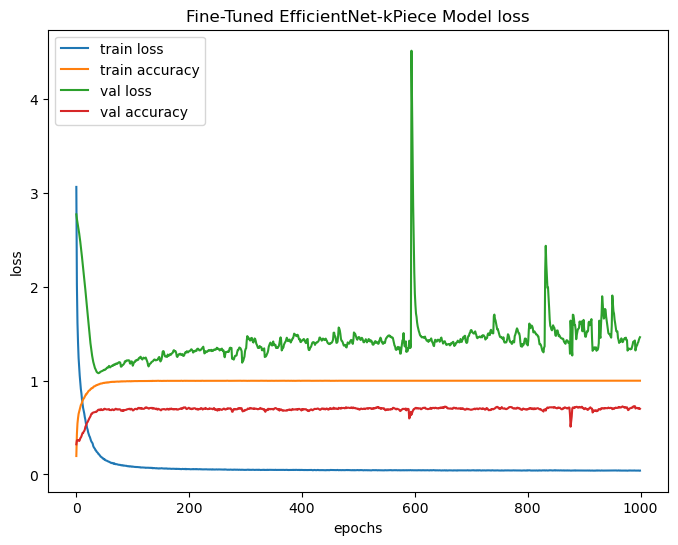

In [37]:
plot_train_loss(history, 'Fine-Tuned EfficientNet-kPiece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [38]:
train_preds = model1.predict([fine_tune_data_train_4P_red, fine_tune_data_train])

2022-10-08 09:08:58.339620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-08 09:08:58.396581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 9s 17ms/step


In [41]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [42]:
train_pred_labels

array([1, 4, 4, ..., 4, 9, 9])

In [43]:
np.sum(train_pred_labels == train_labels['label'])

3336

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [166]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
3597,3781,./Data/train/train/3781.tif,0
12255,12896,./Data/train/train/12896.tif,9
14569,15333,./Data/train/train/15333.tif,7


In [167]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,1.000000,0.998978,0.999488,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [168]:
test_preds = model1.predict(fine_tune_data_test_red)

25/25 [==============================] - 0s 3ms/step


In [169]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [170]:
test_pred_labels

array([11,  8,  6,  7,  1,  9, 13,  9, 14,  1,  6,  0,  7, 14,  1, 11,  0,
        9,  6, 12, 12, 14,  3,  9,  6,  0,  3,  0,  3,  3, 11,  1,  9,  2,
        1,  8,  6,  7,  1,  9,  6, 12, 14,  8,  5, 14,  3, 11, 13,  4,  0,
       10, 12,  0, 11, 14, 15,  6,  9,  2, 15,  9,  2, 11,  4, 10,  8,  0,
        6,  3,  4,  4, 12,  0,  8,  6,  7,  0, 12, 11, 11,  5,  4, 12,  9,
        8,  5, 13, 13, 13, 10, 11,  4, 10,  1, 10, 11,  8, 13, 10,  9, 11,
       12,  9,  1, 14,  8,  2,  5, 10,  7, 10,  9,  4, 12, 14, 12,  1, 10,
        6,  8,  1,  0, 12,  1,  7, 10, 12, 15,  8,  3, 11,  6,  5,  6,  9,
       14, 10,  7, 14, 10,  8, 11, 12,  8, 10,  8,  4,  2, 13,  0,  0,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  4, 10, 13,  8,  2,  8,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 11,  0, 11,  6, 13,  4,
       14,  1,  7, 15,  0,  3,  0, 10, 13, 13, 10,  1, 11,  7,  1,  9,  1,
        9,  5, 13, 15, 12,  1,  9,  8,  7,  9, 13, 12,  4, 12,  8,  0,  9,
       13, 15,  5,  0, 10

In [171]:
np.sum(test_pred_labels == test_labels['label'])

605

In [172]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
7,100,./Data/train/train/100.tif,10
11,164,./Data/train/train/164.tif,15
19,372,./Data/train/train/372.tif,13
...,...,...,...
773,15508,./Data/train/train/15508.tif,10
779,15568,./Data/train/train/15568.tif,9
785,15621,./Data/train/train/15621.tif,15
788,15687,./Data/train/train/15687.tif,12


In [173]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.650794,0.759259,0.700855,54
1,0.529412,0.613636,0.568421,44
2,0.911111,0.953488,0.931818,43
3,0.933333,0.913043,0.923077,46
4,0.810811,0.833333,0.821918,36
5,0.641026,0.500000,0.561798,50
6,0.878049,0.782609,0.827586,46
7,0.784314,0.769231,0.776699,52
8,0.787879,0.962963,0.866667,54
9,0.787234,0.787234,0.787234,47


In [174]:
np.mean(fscore)

0.7564612780924312

#### On Validation Data

Generating Predictions for the Validation Set

In [175]:
valid_preds = model1.predict(fine_tune_data_validation_red)

29/29 [==============================] - 0s 3ms/step


2022-10-07 23:28:45.355855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [176]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

In [177]:
valid_pred_labels

array([11,  6,  4,  8,  3,  8,  1,  1,  2,  4,  3,  0, 12, 12, 13,  9,  1,
        1, 11, 12, 14,  9, 13,  6,  1,  2,  7,  3,  8,  1,  0, 14,  8, 10,
       14,  6, 11,  8,  6, 10,  4, 14, 12,  3,  2, 10,  3,  2,  4,  2, 10,
        0, 10,  0,  1,  9,  2,  8, 13,  1,  2, 11,  4,  5,  5,  8, 11,  7,
        8,  4,  5,  5,  4,  8,  4,  6,  4, 15, 11,  0,  9, 15,  5, 11,  7,
       15, 11, 10,  0, 10, 12,  5, 15, 15,  3,  4, 11, 10,  6,  5,  6, 11,
        1, 12,  7,  1, 15,  9, 10,  1,  7,  7,  7, 14,  2,  4,  1, 14, 12,
        1, 13,  1,  3,  6,  1, 10,  0,  6,  4, 12,  8,  1, 13,  8, 10,  3,
       11, 11,  5,  5,  6,  6,  2,  3,  2,  9,  9,  0,  0, 14, 10, 10,  1,
       11,  7,  3, 14,  1,  1, 14,  3, 11,  2, 13,  7, 14,  4,  5,  7,  9,
       12, 10,  4,  7,  4,  0,  1,  6, 11,  8, 15, 11,  3,  2,  3,  3, 14,
        3, 11,  2,  9,  5,  6,  2,  4,  9,  2,  9, 10,  7,  1, 13,  1,  0,
       15,  1,  4,  1,  4,  4,  8,  6,  6,  7,  4,  4, 13,  3, 10, 12,  1,
        6,  0,  8, 10,  2

### Submission

For Kaggle Submission

In [180]:
roi_info_validation[0]

array([[  6.31446934, 953.5032959 , 124.96561432, 983.04998779,
          1.        ,   1.        ],
       [  6.83573103, 967.67987061, 231.95384216, 982.98071289,
          1.        ,   1.        ],
       [ 21.61216927, 904.17651367, 725.11962891, 909.07617188,
          5.        ,   1.        ],
       [ 35.6613121 ,  15.60731411,  43.65130234,  22.02859116,
          1.        ,   1.        ],
       [ 78.91178131,  29.19843483, 692.08996582, 202.60029602,
          6.        ,   1.        ],
       [110.42622375, 127.7110672 , 637.99682617, 773.59735107,
          2.        ,   1.        ],
       [165.22764587, 847.66424561, 662.84649658, 854.0112915 ,
          5.        ,   1.        ],
       [532.09185791, 859.65454102, 639.74468994, 874.27435303,
          1.        ,   1.        ],
       [712.800354  ,   4.76252604, 715.38275146,  71.32498932,
          1.        ,   1.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0. 

In [178]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,11
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,7
896,18697,12
897,18698,8
898,18699,3


In [179]:
submission_data.to_csv('./Submissions/submission-effnet-kPiece-PCA.csv', index=False)